In [166]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from functools import partial
#from google.colab import files
import time
import os
from typing import Tuple
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [167]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 3070


In [168]:
LENGTH = 1.                     # Domain size in x axis. Always starts at 0
TOTAL_TIME = 1.                 # Domain size in t axis. Always starts at 0
N_POINTS = 15                   # Number of in single axis
N_POINTS_PLOT = 150             # Number of points in single axis used in plotting
WEIGHT_RESIDUAL = 20.0          # Weight of residual part of loss function
WEIGHT_INITIAL = 1.0            # Weight of initial part of loss function
WEIGHT_BOUNDARY = 10.0          # Weight of boundary part of loss function
LAYERS = 2
NEURONS_PER_LAYER = 600
EPOCHS = 30_000
LEARNING_RATE = 0.002

In [169]:
## Initial condition

def initial_condition(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    # r = torch.sqrt((x-0.5)**2 + (y-0.5)**2)
    # res = (r - 0.25) * (r < 0.25)
    # res = (torch.sqrt((x-0.5)**2 + (y-0.5)**2) - 0.25)**2 *  # (torch.sqrt((x-0.5)**2 + (y-0.5)**2) - 0.25)**2
    # res = torch.exp(-(r*7)**2) / 2
    return torch.sqrt(0*x)

In [170]:
## PINN


class PINN(nn.Module):
    """Simple neural network accepting two features as input and returning a single output

    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(3, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self, x, y, t):

        x_stack = torch.cat([x, y, t], dim=1)
        out = self.act(self.layer_in(x_stack))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        logits = self.layer_out(out)

        return logits

    def device(self):
        return next(self.parameters()).device

def f(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return pinn(x, y, t)


def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def dfdt(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = f(pinn, x, y, t)
    return df(f_value, t, order=order)


def dfdx(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = f(pinn, x, y, t)
    return df(f_value, x, order=order)

def dfdy(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = f(pinn, x, y, t)
    return df(f_value, y, order=order)

# CANNON ADDED HERE ! ! !
grid_size = 1.0
cannon_x_loc = grid_size / 2
cannon_shot_time = 0.4
cannon_strength_x = 3.5
cannon_strength_y = 4.5
cone_limiter = 6.0
max_alpha = np.pi / cone_limiter
wave_speed = 2.0
iterations = 1.0

def bx(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = cannon(pinn, x, y, t)
    return df(f_value, y, order=order) * cannon_strength_x

def by(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = cannon(pinn, x, y, t)
    return df(f_value, y, order=order) * cannon_strength_y


def cannon(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    iter = t  # Assuming t represents iteration here
    zero_tensor = torch.zeros_like(iter)

    i_denom = torch.tensor((iterations / wave_speed) - cannon_shot_time, device=iter.device)
    valid_i_denom = i_denom > 0

    time = (iter - cannon_shot_time) * grid_size / i_denom
    time = torch.where(valid_i_denom, time, zero_tensor)

    valid_y = y <= time

    x_prim = torch.abs(cannon_x_loc - x)
    alpha_rad = torch.atan(x_prim / time)
    valid_alpha = alpha_rad < max_alpha

    y_prim = torch.sqrt(time * time - x_prim * x_prim)
    valid_y_prim = y <= y_prim

    cos_term = torch.cos(alpha_rad * cone_limiter * 0.5)

    cannon_value = (y_prim - y) * cos_term
    valid_condition = valid_i_denom & valid_y & valid_alpha & valid_y_prim
    cannon_value = torch.where(valid_condition, cannon_value, zero_tensor)

    return cannon_value
# CANNON ADDED HERE ! ! !

# Loss function

In [171]:
def get_boundary_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    """
         .+------+
       .' |    .'|
      +---+--+'  |
      |   |  |   |
    y |  ,+--+---+
      |.'    | .' t
      +------+'
         x
    """
    x_linspace = torch.linspace(x_domain[0], x_domain[1], n_points)
    y_linspace = torch.linspace(y_domain[0], y_domain[1], n_points)
    t_linspace = torch.linspace(t_domain[0], t_domain[1], n_points)

    x_grid, t_grid = torch.meshgrid( x_linspace, t_linspace, indexing="ij")
    y_grid, _      = torch.meshgrid( y_linspace, t_linspace, indexing="ij")

    x_grid = x_grid.reshape(-1, 1).to(device)
    x_grid.requires_grad = requires_grad
    y_grid = y_grid.reshape(-1, 1).to(device)
    y_grid.requires_grad = requires_grad
    t_grid = t_grid.reshape(-1, 1).to(device)
    t_grid.requires_grad = requires_grad

    x0 = torch.full_like(t_grid, x_domain[0], requires_grad=requires_grad)
    x1 = torch.full_like(t_grid, x_domain[1], requires_grad=requires_grad)
    y0 = torch.full_like(t_grid, y_domain[0], requires_grad=requires_grad)
    y1 = torch.full_like(t_grid, y_domain[1], requires_grad=requires_grad)

    down    = (x_grid, y0,     t_grid)
    up      = (x_grid, y1,     t_grid)
    left    = (x0,     y_grid, t_grid)
    right   = (x1,     y_grid, t_grid)

    return down, up, left, right

def get_initial_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_linspace = torch.linspace(x_domain[0], x_domain[1], n_points)
    y_linspace = torch.linspace(y_domain[0], y_domain[1], n_points)
    x_grid, y_grid = torch.meshgrid( x_linspace, y_linspace, indexing="ij")
    x_grid = x_grid.reshape(-1, 1).to(device)
    x_grid.requires_grad = requires_grad
    y_grid = y_grid.reshape(-1, 1).to(device)
    y_grid.requires_grad = requires_grad
    t0 = torch.full_like(x_grid, t_domain[0], requires_grad=requires_grad)
    return (x_grid, y_grid, t0)

def get_interior_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_raw = torch.linspace(x_domain[0], x_domain[1], steps=n_points, requires_grad=requires_grad)
    y_raw = torch.linspace(y_domain[0], y_domain[1], steps=n_points, requires_grad=requires_grad)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=n_points, requires_grad=requires_grad)
    grids = torch.meshgrid(x_raw, y_raw, t_raw, indexing="ij")

    x = grids[0].reshape(-1, 1).to(device)
    y = grids[1].reshape(-1, 1).to(device)
    t = grids[2].reshape(-1, 1).to(device)

    return x, y, t

In [172]:
class Loss:
    def __init__(
        self,
        x_domain: Tuple[float, float],
        y_domain: Tuple[float, float],
        t_domain: Tuple[float, float],
        n_points: int,
        initial_condition: Callable,
        weight_r: float = 1.0,
        weight_b: float = 1.0,
        weight_i: float = 1.0,
        verbose: bool = False,
    ):
        self.x_domain = x_domain
        self.y_domain = y_domain
        self.t_domain = t_domain
        self.n_points = n_points
        self.initial_condition = initial_condition
        self.weight_r = weight_r
        self.weight_b = weight_b
        self.weight_i = weight_i
        self.Kx=1.0
        self.Ky=0.01

    def dTy(self,y,t):
      res = torch.where(t < 0.5, -2, 2)
      #res1 = torch.where(t % 1 < 0.5, -2.6, 2.6)
      #res2 = torch.where(torch.logical_and(t < 1, y < 0.8), res1, -2.6)
      #res3 = torch.where(torch.logical_and(t < 1, y >=0.8), res2, 0)
      return res.to(device)

    def source(self,y,t):
      d=0.7
      res = torch.clamp((torch.cos(t*math.pi) - d)*1/(1-d), min = 0)
      res2 = (150 - 1200 * y) * res
      res3 = torch.where(t <= 0.3, res2, 0)
      res4 = torch.where(y <= 0.125, res3, 0)
      return res4.to(device)

    def residual_loss(self, pinn: PINN):
        x, y, t = get_interior_points(
            self.x_domain, self.y_domain, self.t_domain,
            self.n_points, pinn.device())
        loss = dfdt(pinn, x, y, t).to(device)\
            - self.dTy(y, t) * dfdy(pinn, x, y, t).to(device)\
            - self.Kx * dfdx(pinn, x, y, t,order=2).to(device)\
            - self.Ky * dfdy(pinn, x, y, t, order=2).to(device)\
            - self.source(y,t).to(device)\
            - bx(pinn, x, y, t).to(device) * dfdx(pinn, x, y, t).to(device)\
            - by(pinn, x, y, t).to(device) * dfdy(pinn, x, y, t).to(device)
        # CANNON ADDED HERE ! ! !
        return loss.pow(2).mean()

    def initial_loss(self, pinn: PINN):
        x, y, t = get_initial_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        pinn_init = self.initial_condition(x, y)
        loss = f(pinn, x, y, t) - pinn_init
        return loss.pow(2).mean()

    def boundary_loss(self, pinn: PINN):
        down, up, left, right = get_boundary_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        x_down,  y_down,  t_down    = down
        x_up,    y_up,    t_up      = up
        x_left,  y_left,  t_left    = left
        x_right, y_right, t_right   = right

        loss_down  = dfdy( pinn, x_down,  y_down,  t_down  )
        loss_up    = dfdy( pinn, x_up,    y_up,    t_up    )
        loss_left  = dfdx( pinn, x_left,  y_left,  t_left  )
        loss_right = dfdx( pinn, x_right, y_right, t_right )

        return loss_down.pow(2).mean()  + \
            loss_up.pow(2).mean()    + \
            loss_left.pow(2).mean()  + \
            loss_right.pow(2).mean()

    def verbose(self, pinn: PINN):
        """
        Returns all parts of the loss function

        Not used during training! Only for checking the results later.
        """
        residual_loss = self.residual_loss(pinn)
        initial_loss = self.initial_loss(pinn)
        boundary_loss = self.boundary_loss(pinn)

        final_loss = \
            self.weight_r * residual_loss + \
            self.weight_i * initial_loss + \
            self.weight_b * boundary_loss

        return final_loss, residual_loss, initial_loss, boundary_loss

    def __call__(self, pinn: PINN):
        """
        Allows you to use instance of this class as if it was a function:

        ```
            >>> loss = Loss(*some_args)
            >>> calculated_loss = loss(pinn)
        ```
        """
        return self.verbose(pinn)

# Train function

In [173]:
def train_model(
    nn_approximator: PINN,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000
) -> PINN:

    optimizer = torch.optim.Adam(nn_approximator.parameters(), lr=learning_rate)
    #optimizer = torch.optim.LBFGS(nn_approximator.parameters())

    decayRate = 0.9998
    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)
    loss_values = []
    loss_residual_values = []
    loss_initial_values = []
    loss_boundary_values = []
    for epoch in range(max_epochs):

        try:
            loss_total = loss_fn(nn_approximator)
            loss: torch.Tensor = loss_total[0]
            def getLoss():
              return loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch < 30000:
              my_lr_scheduler.step()

            loss_values.append(loss.item())
            loss_residual_values.append(loss_total[1].item())
            loss_initial_values.append(loss_total[2].item())
            loss_boundary_values.append(loss_total[3].item())
            if (epoch + 1) % 1000 == 0:
                print(f"Epoch: {epoch + 1} - Loss: {float(loss):>7f}")

        except KeyboardInterrupt:
            break

    return nn_approximator, np.array(loss_values), np.array(loss_residual_values), np.array(loss_initial_values), np.array(loss_boundary_values)

# Plotting functions

In [174]:
def plot_solution(pinn: PINN, x: torch.Tensor, t: torch.Tensor, figsize=(8, 6), dpi=100):

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    x_raw = torch.unique(x).reshape(-1, 1)
    t_raw = torch.unique(t)

    def animate(i):

        if not i % 10 == 0:
            t_partial = torch.ones_like(x_raw) * t_raw[i]
            f_final = f(pinn, x_raw, t_partial)
            ax.clear()
            ax.plot(
                x_raw.detach().numpy(), f_final.detach().numpy(), label=f"Time {float(t[i])}"
            )
            ax.set_ylim(-1, 1)
            ax.legend()

    n_frames = t_raw.shape[0]
    return FuncAnimation(fig, animate, frames=n_frames, interval=100, repeat=False)

def plot_color(z: torch.Tensor, x: torch.Tensor, y: torch.Tensor, n_points_x, n_points_t, title, figsize=(8, 6), dpi=100, cmap="viridis"):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    z_raw = z.detach().cpu().numpy()
    x_raw = x.detach().cpu().numpy()
    y_raw = y.detach().cpu().numpy()
    X = x_raw.reshape(n_points_x, n_points_t)
    Y = y_raw.reshape(n_points_x, n_points_t)
    Z = z_raw.reshape(n_points_x, n_points_t)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    c = ax.pcolormesh(X, Y, Z, cmap=cmap)
    fig.colorbar(c, ax=ax)

    return fig

def plot_3D(z: torch.Tensor, x: torch.Tensor, y: torch.Tensor, n_points_x, n_points_t, title, figsize=(8, 6), dpi=100, limit=0.2):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    z_raw = z.detach().cpu().numpy()
    x_raw = x.detach().cpu().numpy()
    y_raw = y.detach().cpu().numpy()
    X = x_raw.reshape(n_points_x, n_points_t)
    Y = y_raw.reshape(n_points_x, n_points_t)
    Z = z_raw.reshape(n_points_x, n_points_t)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axes.set_zlim3d(bottom=-limit, top=limit)

    c = ax.plot_surface(X, Y, Z)

    return fig

def running_average(y, window=100):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

# Running the code

## Train data

In [175]:
#pinn = PINN(LAYERS, NEURONS_PER_LAYER, act=nn.Tanh()).to(device)

pinn = PINN(LAYERS, NEURONS_PER_LAYER, act=nn.GELU()).to(device)


x_domain = [0.0, LENGTH]
y_domain = [0.0, LENGTH]
t_domain = [0.0, TOTAL_TIME]

# train the PINN
loss_fn = Loss(
    x_domain,
    y_domain,
    t_domain,
    N_POINTS,
    initial_condition,
    WEIGHT_RESIDUAL,
    WEIGHT_INITIAL,
    WEIGHT_BOUNDARY
)

pinn_trained, loss_values, loss_residual_values, loss_initial_values, loss_boundary_values = train_model(
    pinn, loss_fn=loss_fn, learning_rate=LEARNING_RATE, max_epochs=EPOCHS)

pinn = pinn.cpu()

# losses = loss_fn.verbose(pinn)
# print(f'Total loss: \t{losses[0]:.5f}    ({losses[0]:.3E})')
# print(f'Interior loss: \t{losses[1]:.5f}    ({losses[1]:.3E})')
# print(f'Initial loss: \t{losses[2]:.5f}    ({losses[2]:.3E})')
# print(f'Bondary loss: \t{losses[3]:.5f}    ({losses[3]:.3E})')

Epoch: 1000 - Loss: 60.926022
Epoch: 2000 - Loss: 39.687099
Epoch: 3000 - Loss: 21.223438
Epoch: 4000 - Loss: 10.212054
Epoch: 5000 - Loss: 5.774698
Epoch: 6000 - Loss: 3.671417
Epoch: 7000 - Loss: 2.395590
Epoch: 8000 - Loss: 1.698478
Epoch: 9000 - Loss: 1.266641
Epoch: 10000 - Loss: 1.060100
Epoch: 11000 - Loss: 0.766346
Epoch: 12000 - Loss: 0.615009
Epoch: 13000 - Loss: 0.504244
Epoch: 14000 - Loss: 0.416381
Epoch: 15000 - Loss: 0.352281
Epoch: 16000 - Loss: 0.302474
Epoch: 17000 - Loss: 0.266577
Epoch: 18000 - Loss: 0.231170
Epoch: 19000 - Loss: 0.206229
Epoch: 20000 - Loss: 0.184365
Epoch: 21000 - Loss: 0.165650
Epoch: 22000 - Loss: 0.149470
Epoch: 23000 - Loss: 0.135365
Epoch: 24000 - Loss: 0.123216
Epoch: 25000 - Loss: 0.113020
Epoch: 26000 - Loss: 0.104216
Epoch: 27000 - Loss: 0.096324
Epoch: 28000 - Loss: 0.089513
Epoch: 29000 - Loss: 0.083619
Epoch: 30000 - Loss: 0.078423


# Plotting

Total loss: 	0.07842    (7.842E-02)
Interior loss: 	0.00176    (1.755E-03)
Initial loss: 	0.00048    (4.765E-04)
Bondary loss: 	0.03855    (3.855E-02)


C:\Users\superuser\AppData\Local\Temp\ipykernel_9612\1562848281.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize, dpi=dpi)


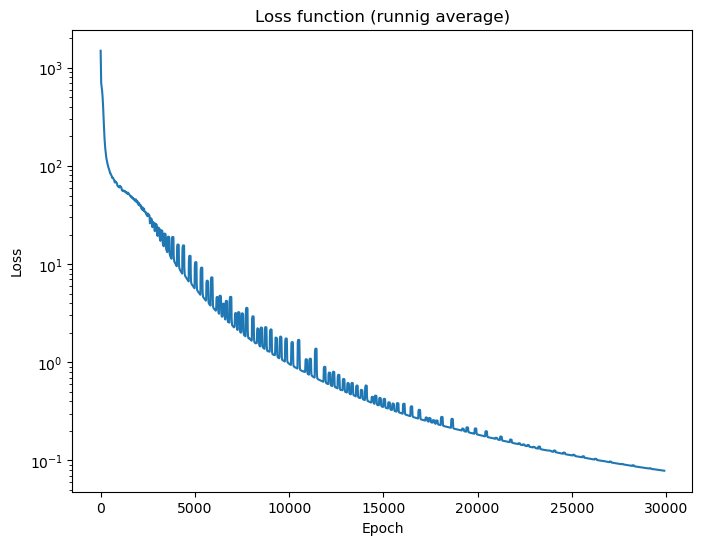

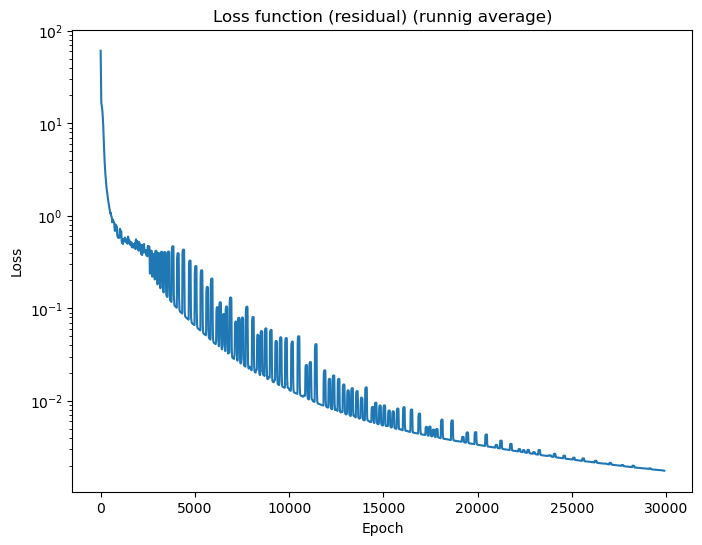

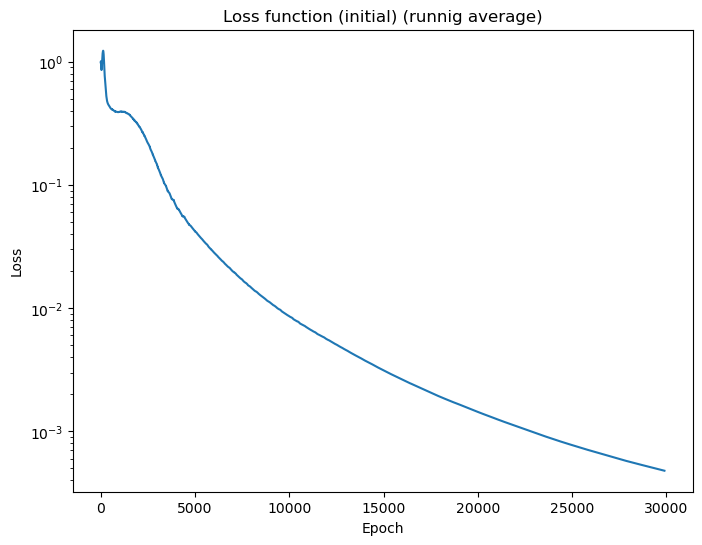

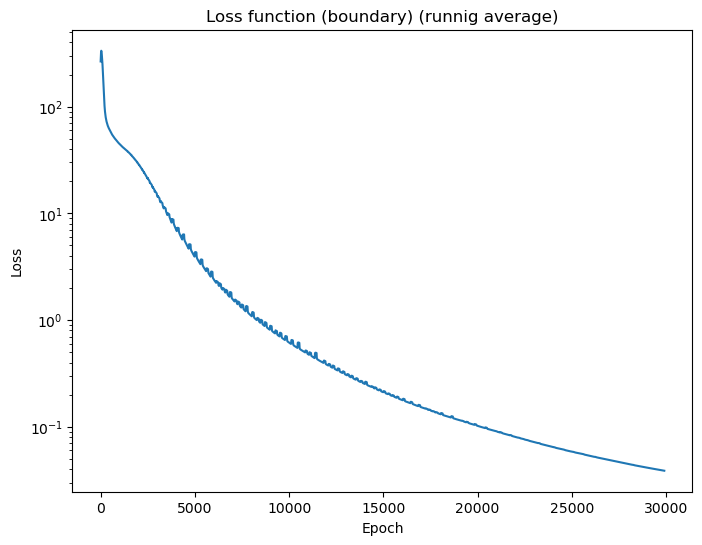

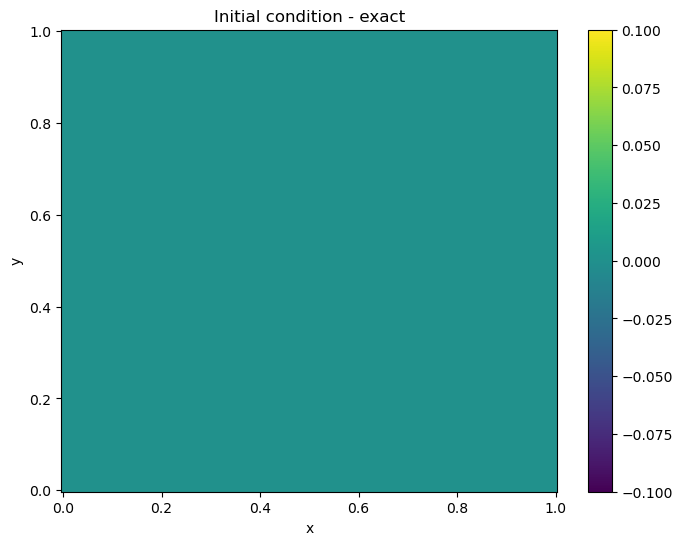

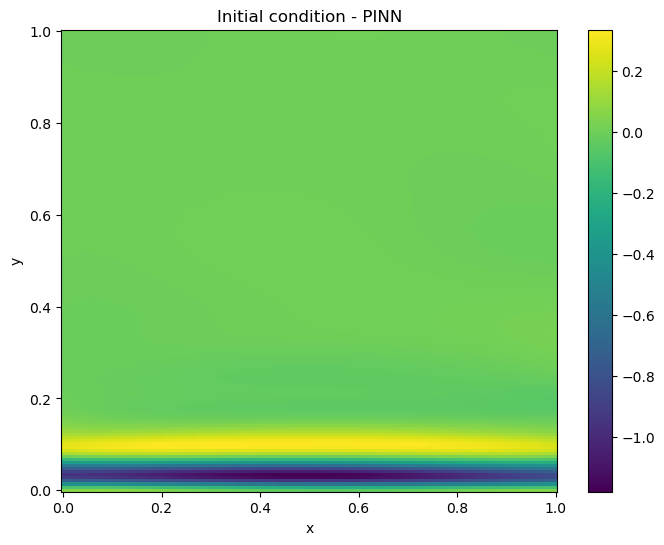

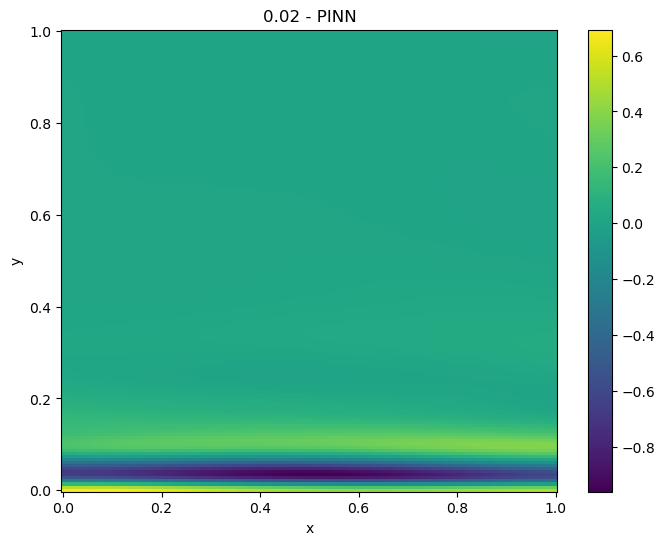

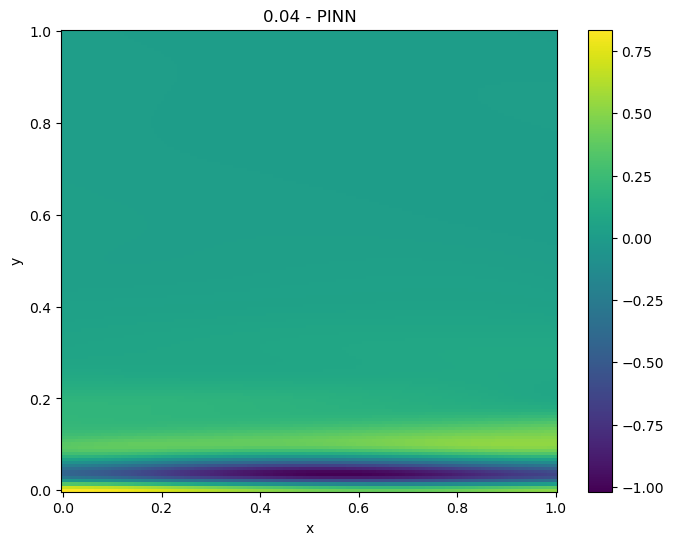

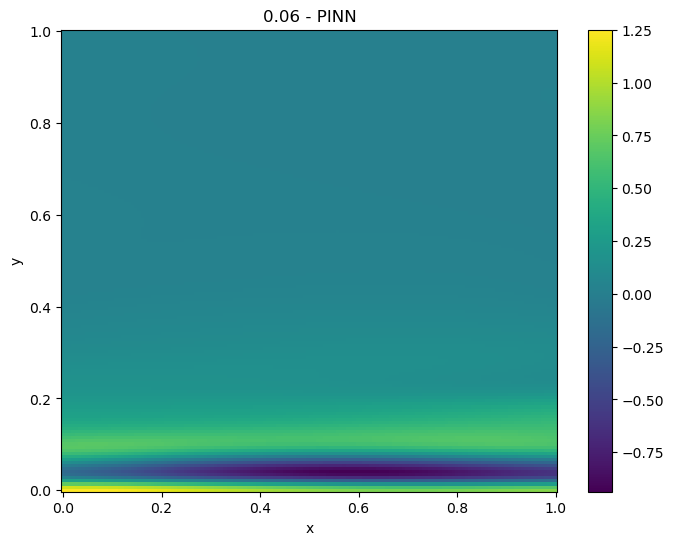

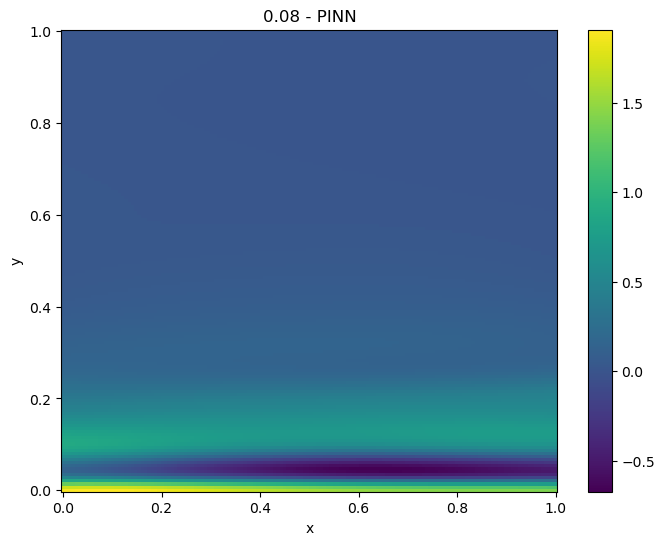

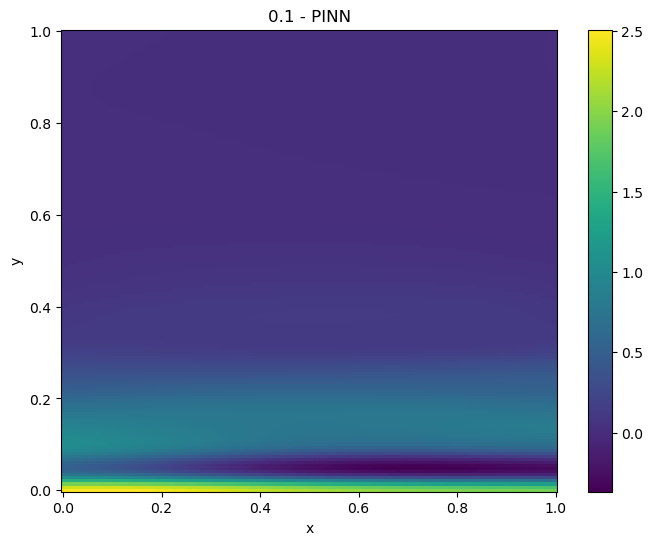

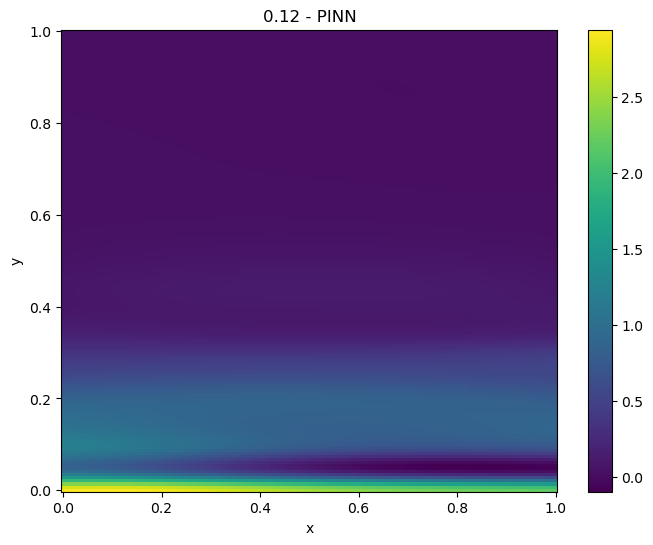

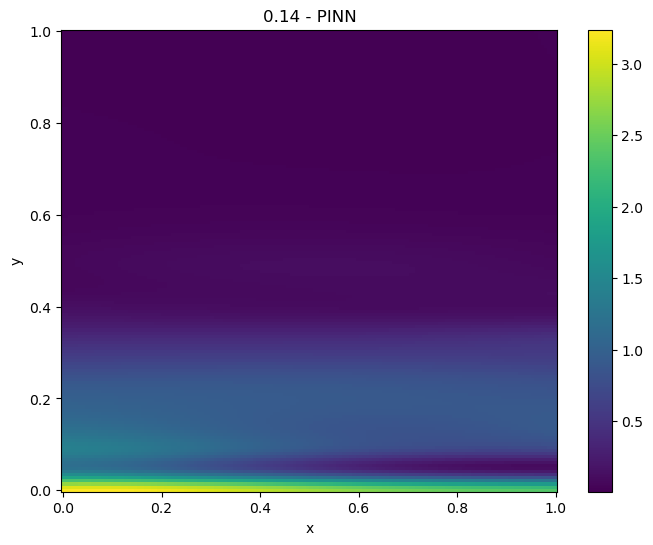

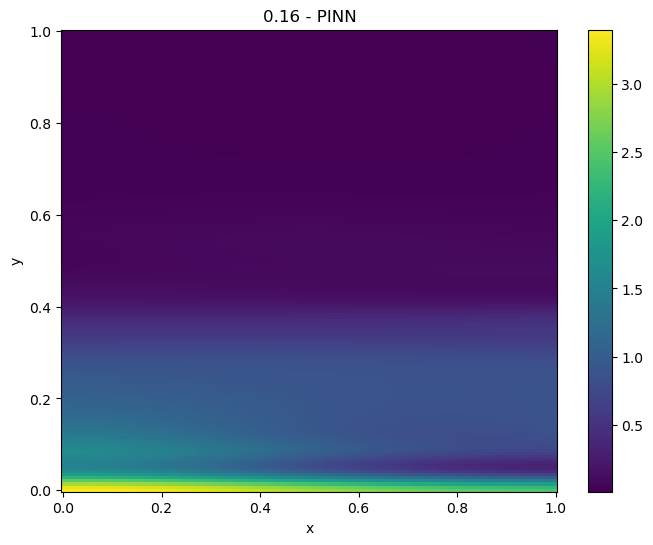

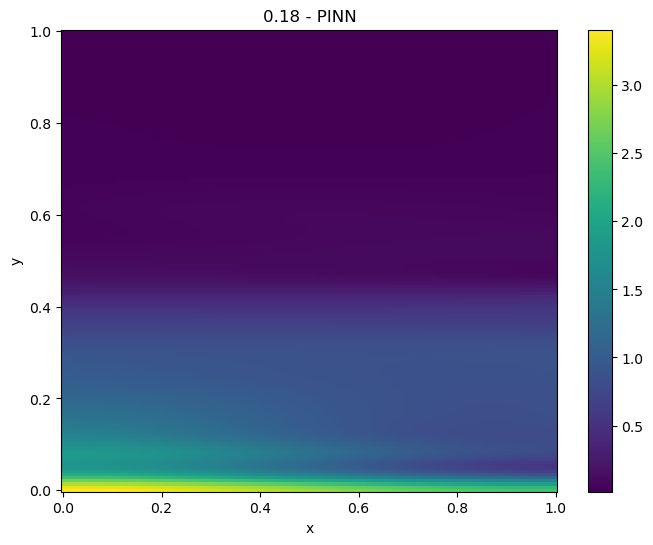

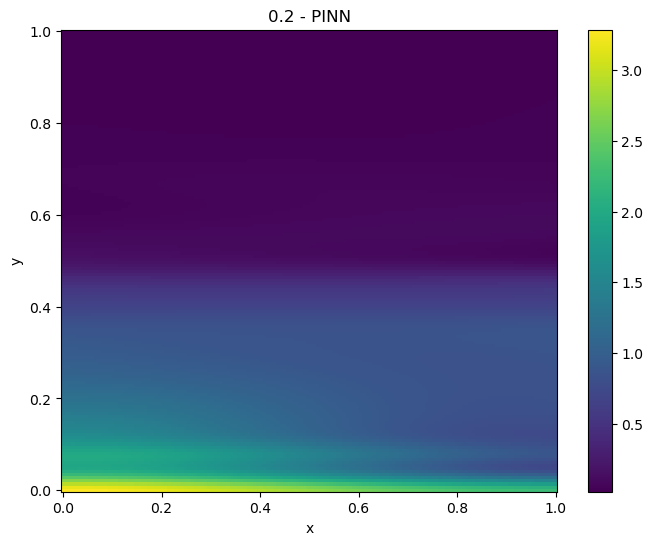

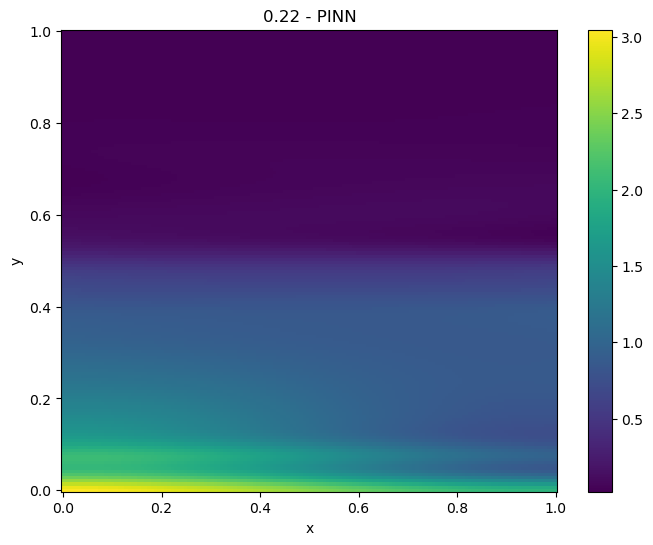

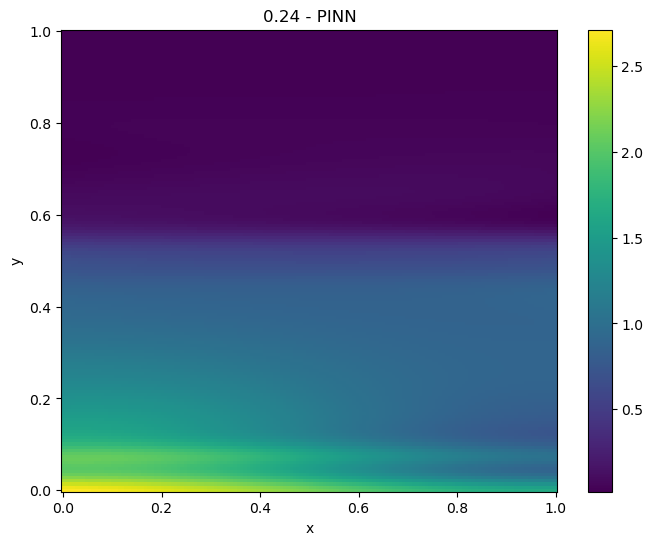

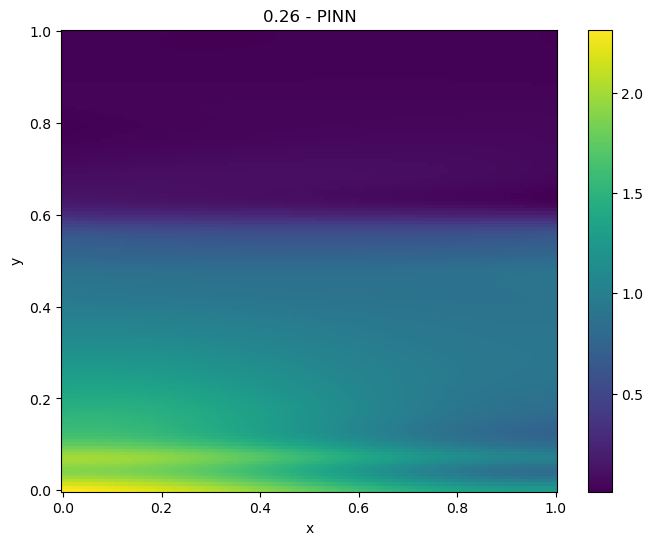

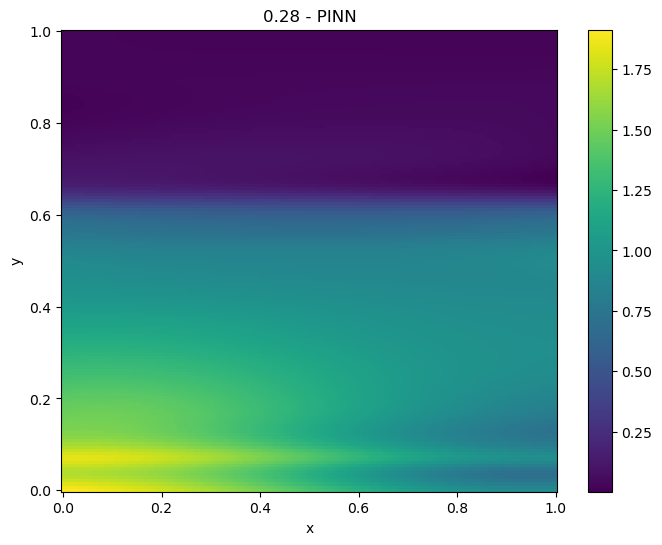

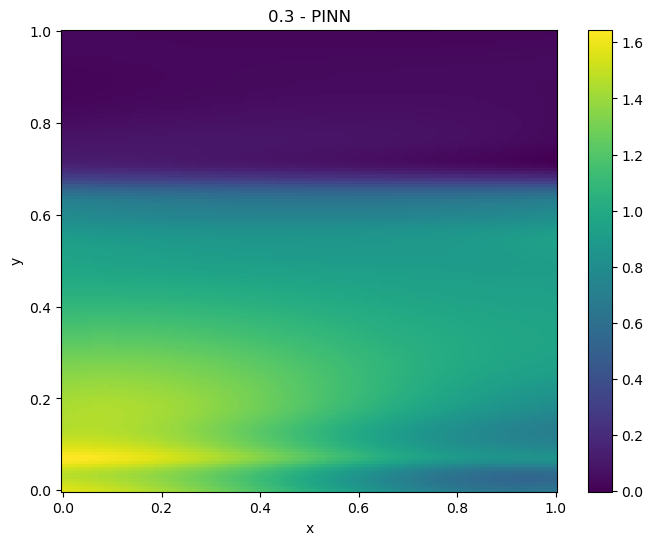

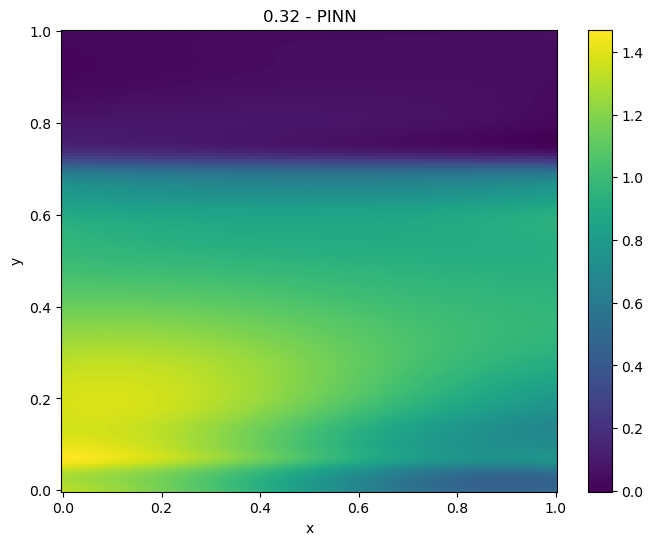

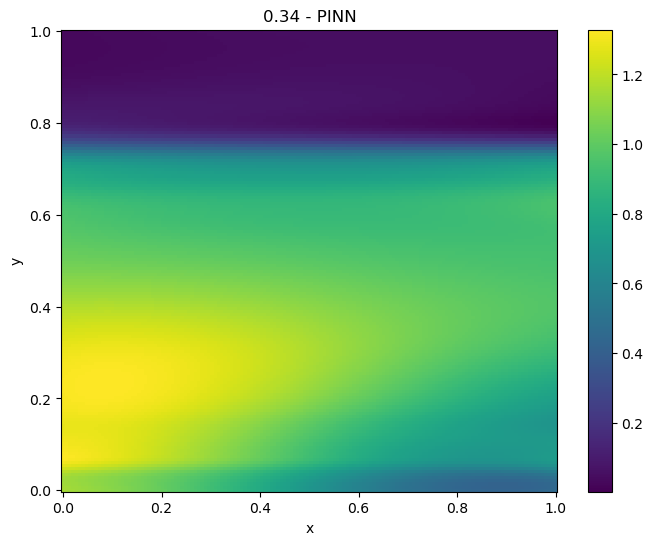

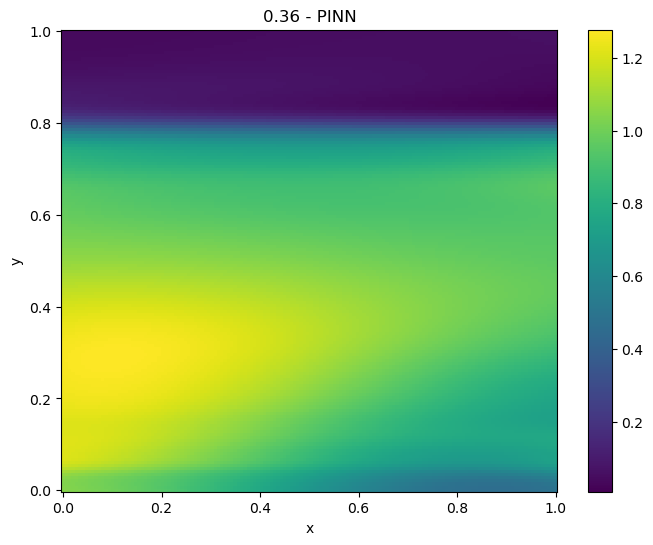

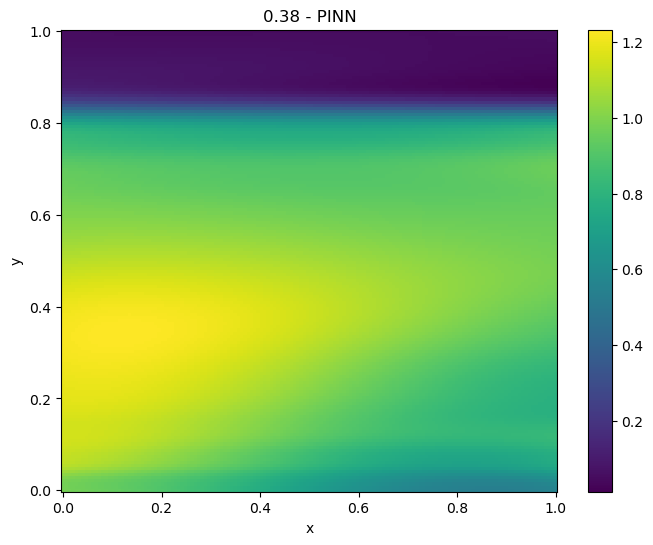

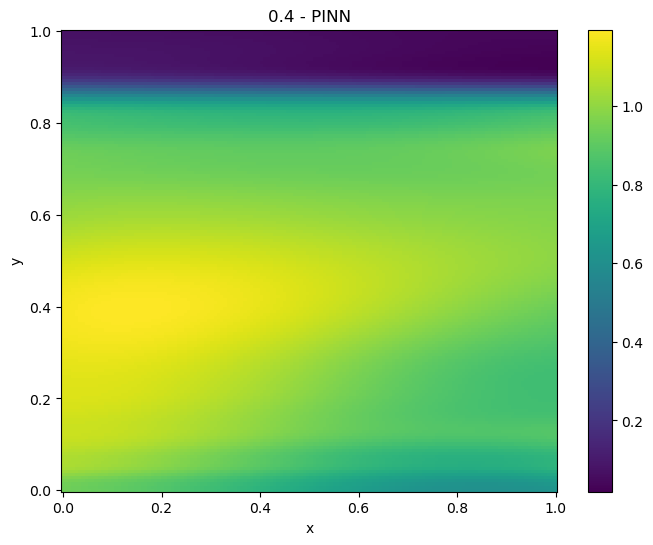

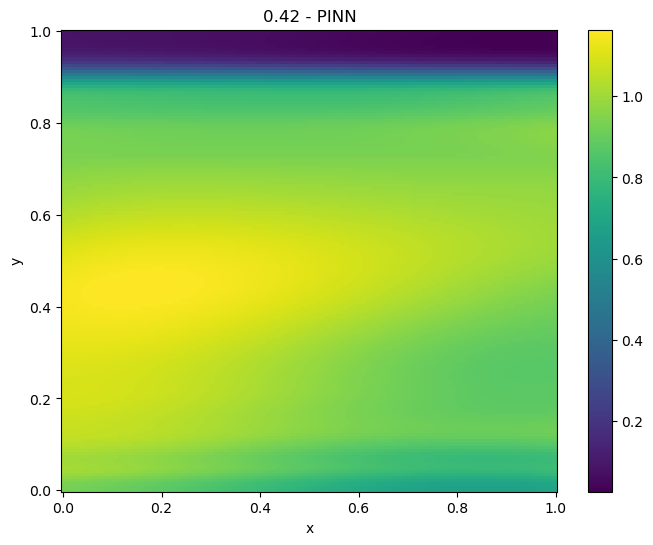

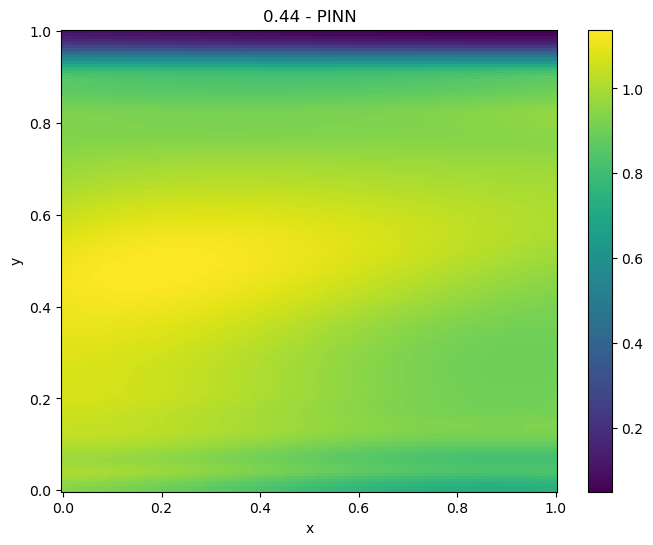

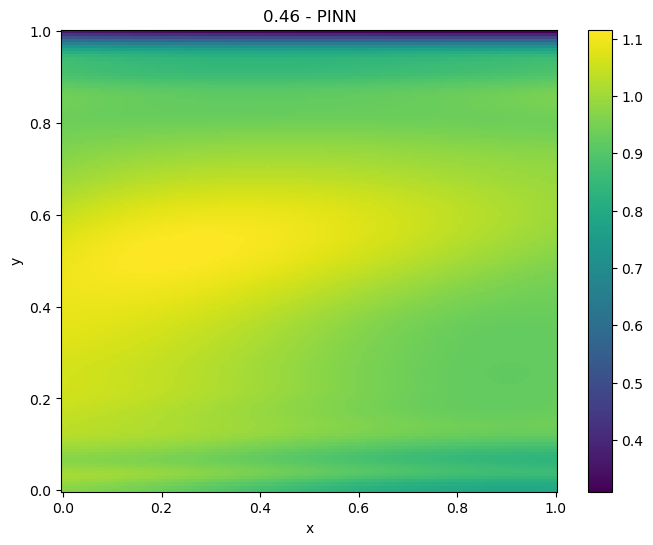

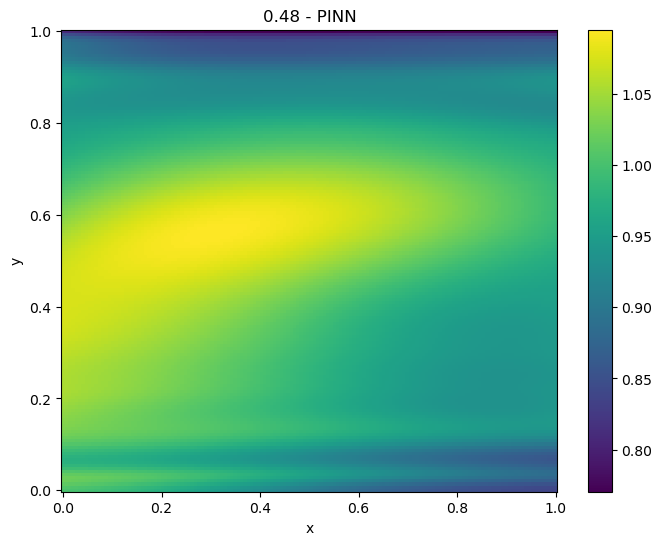

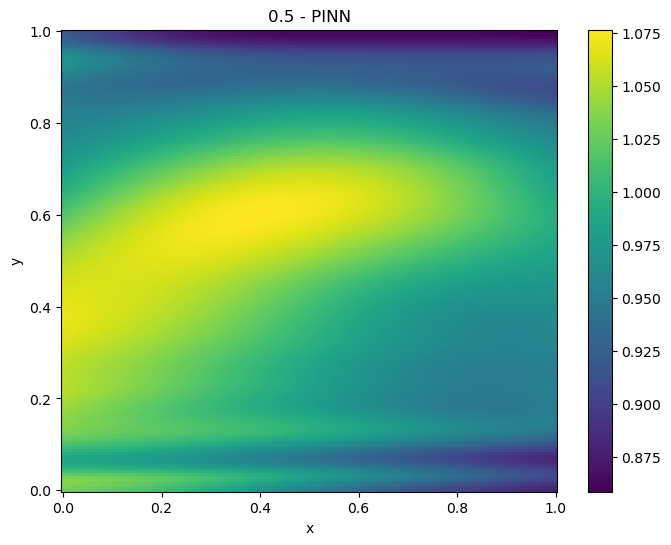

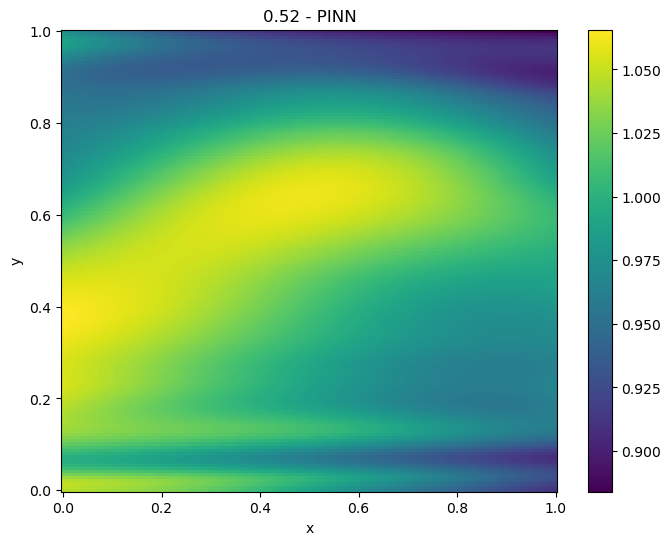

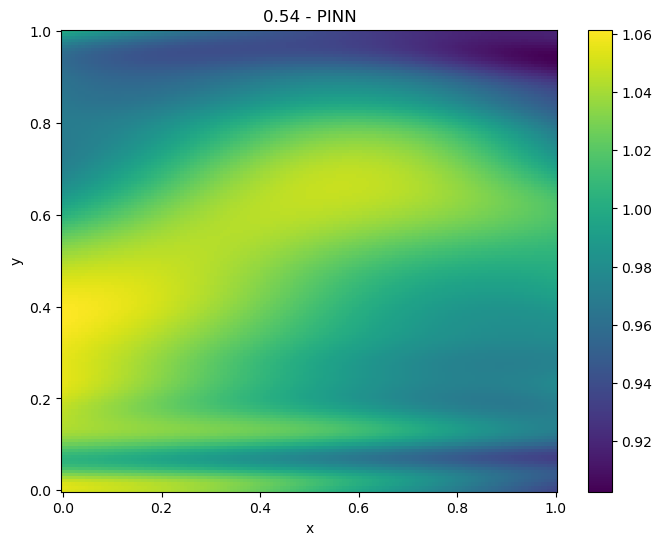

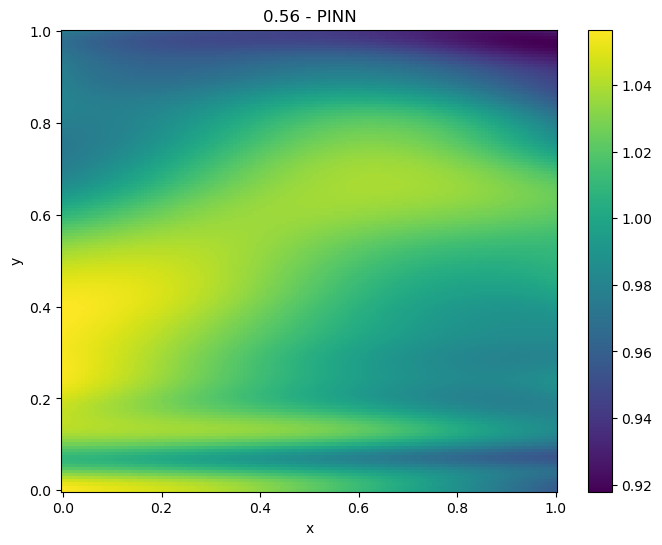

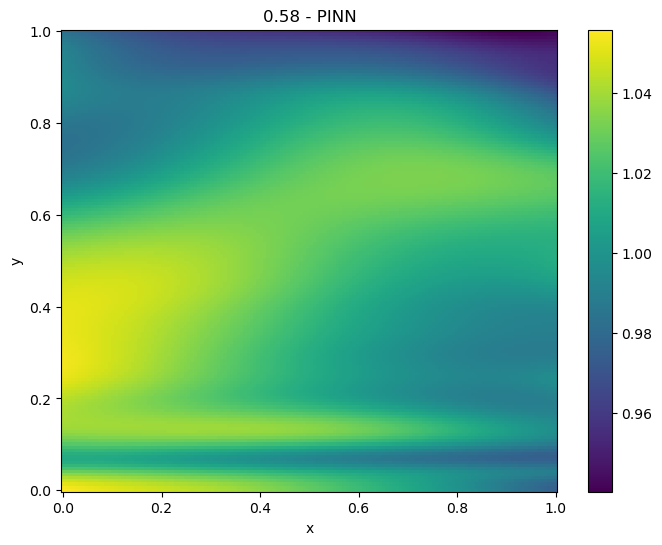

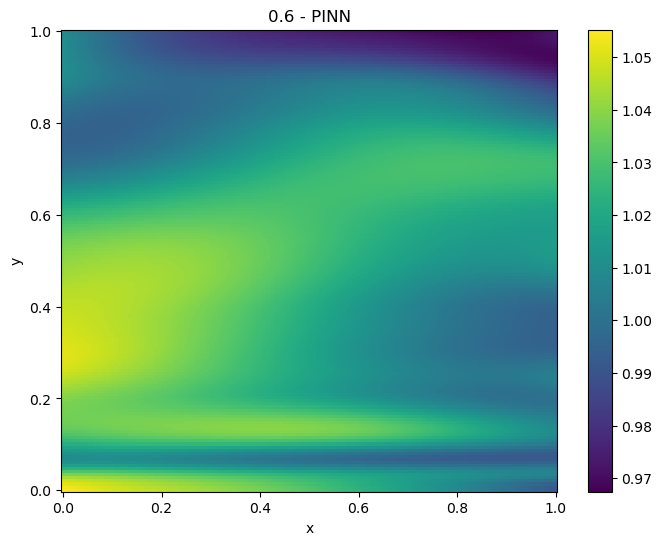

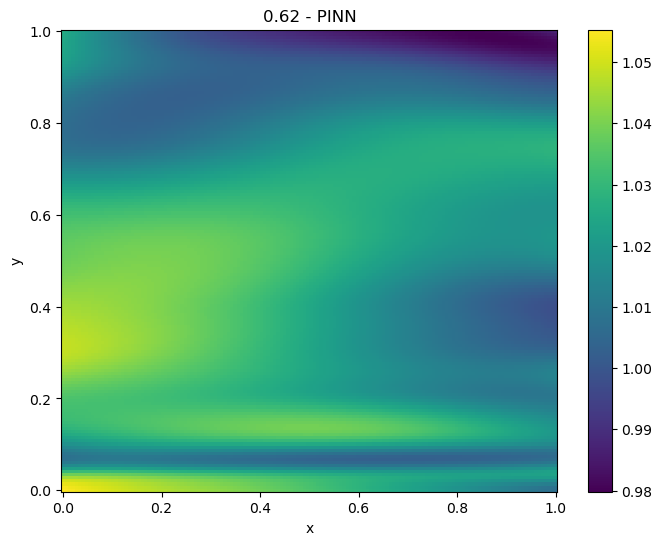

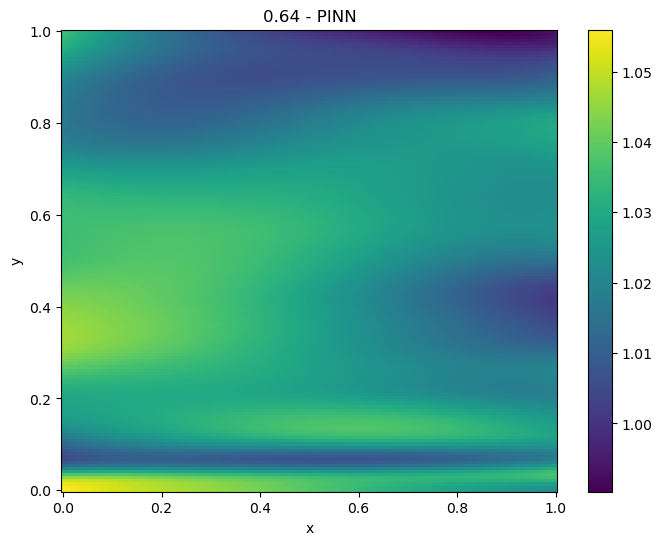

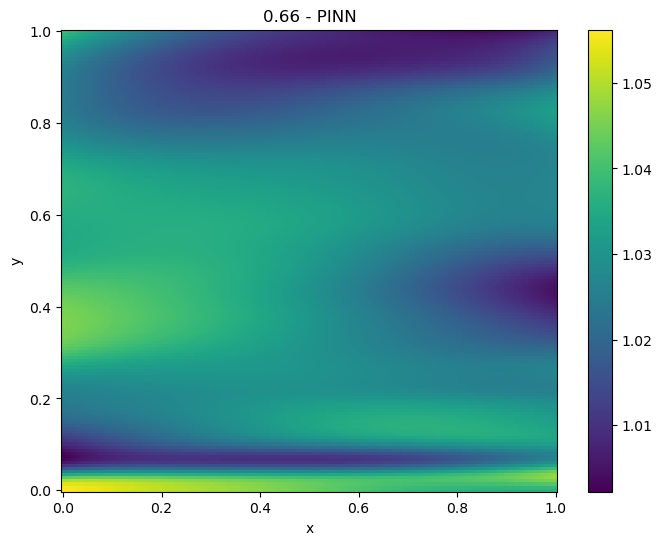

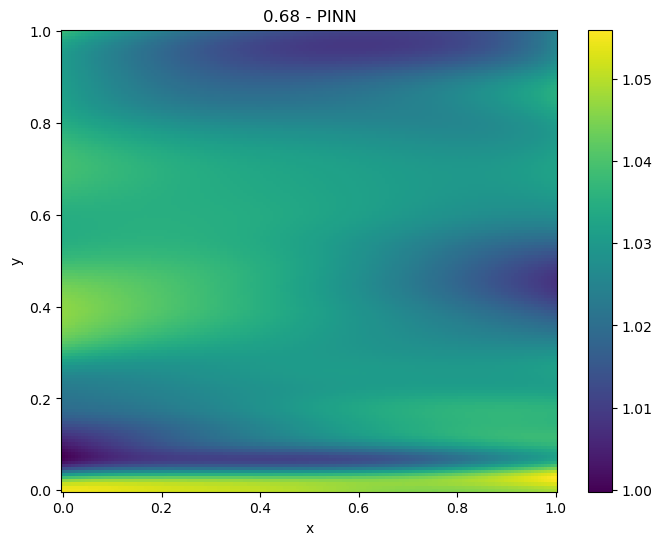

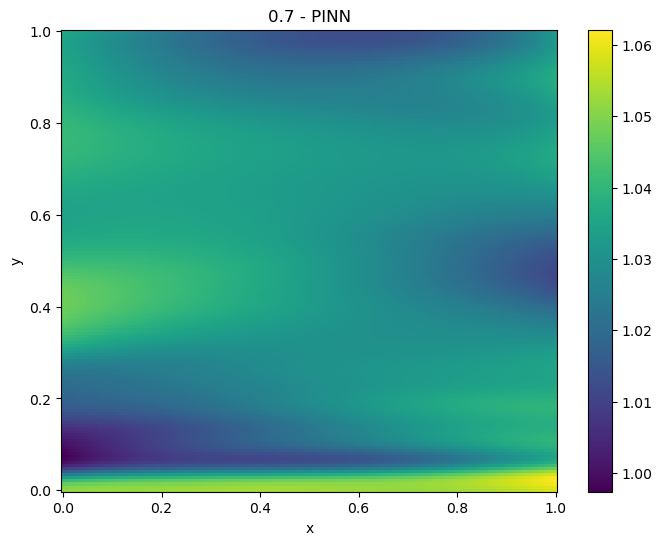

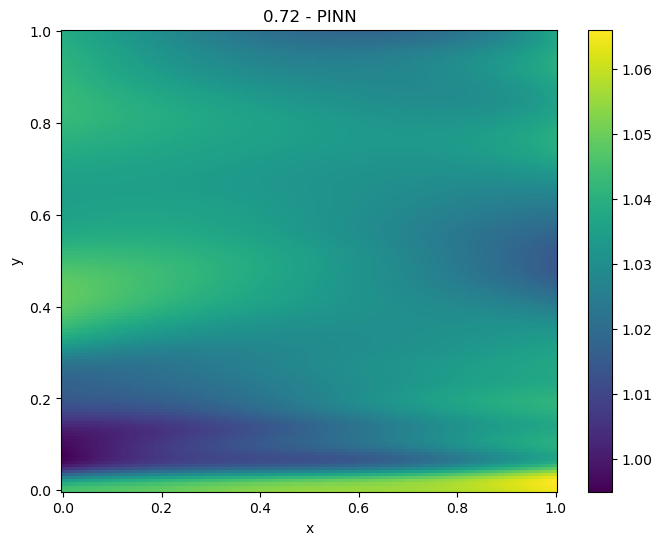

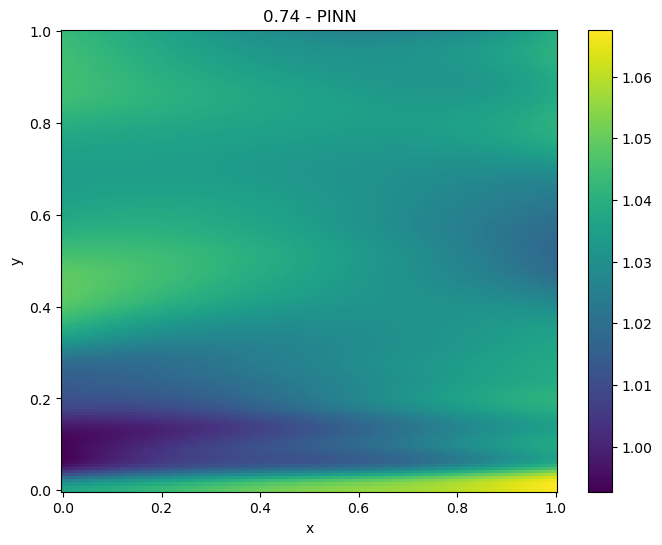

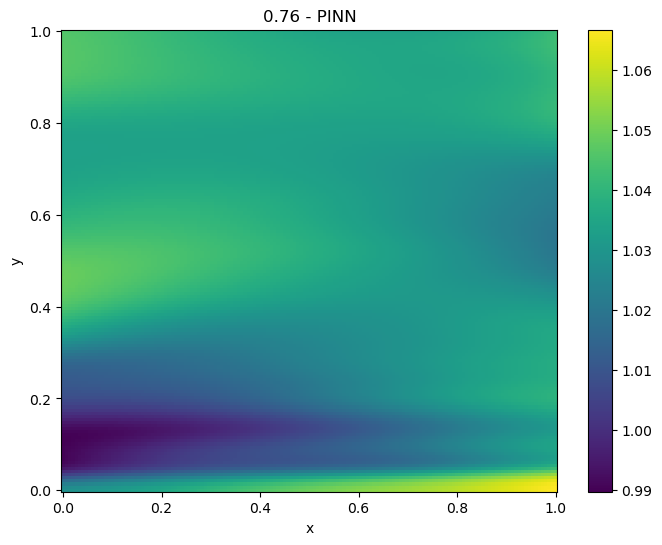

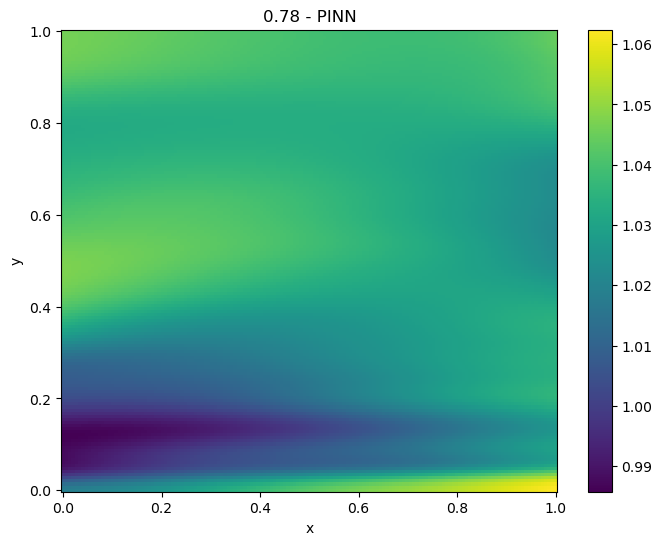

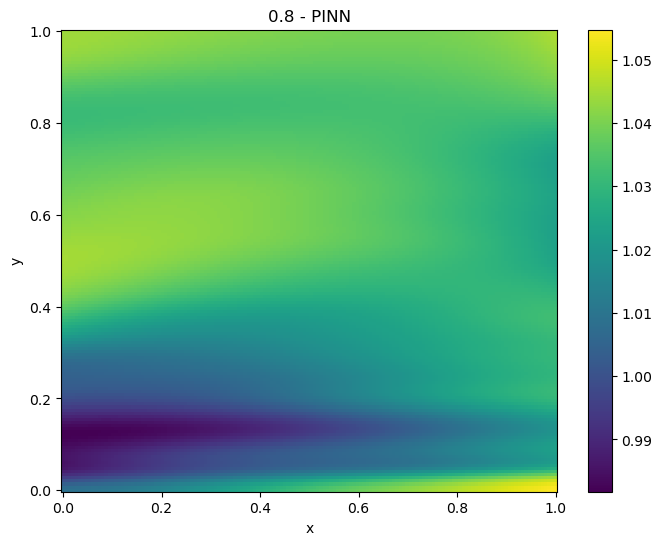

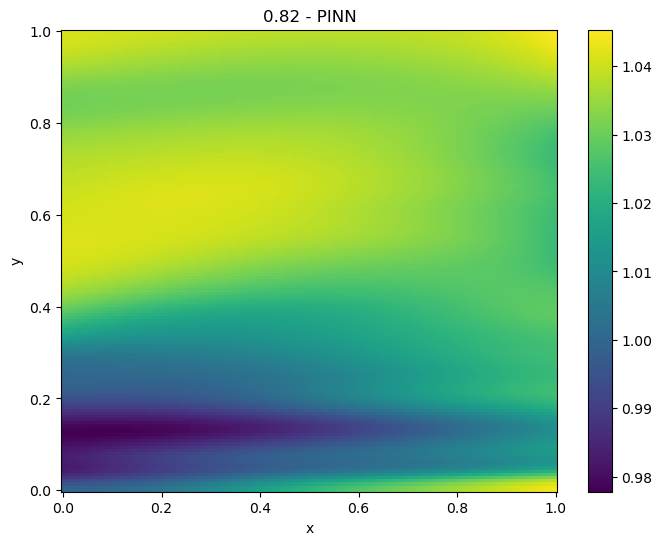

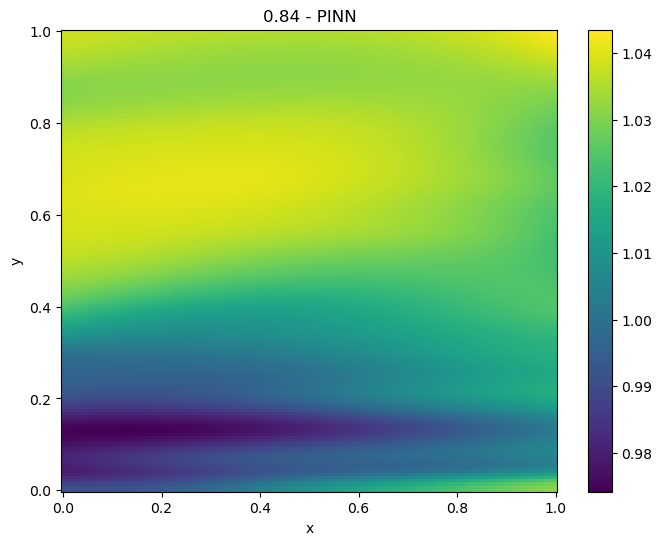

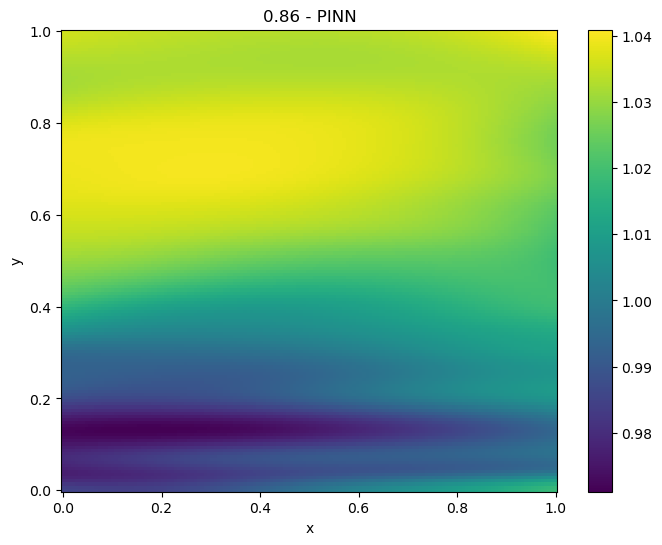

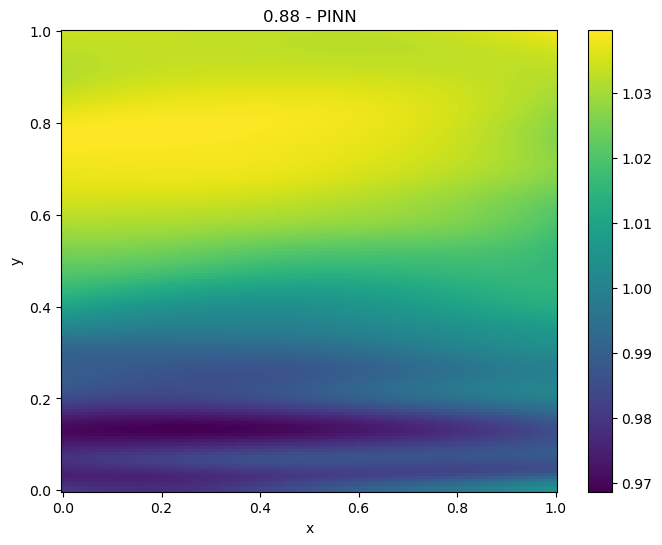

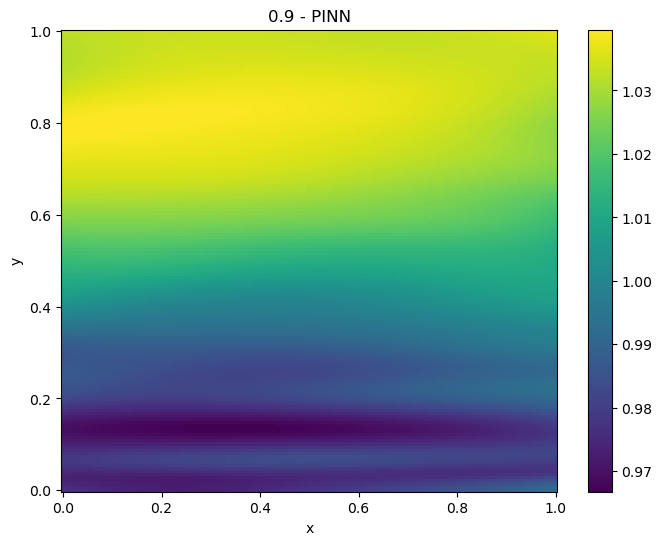

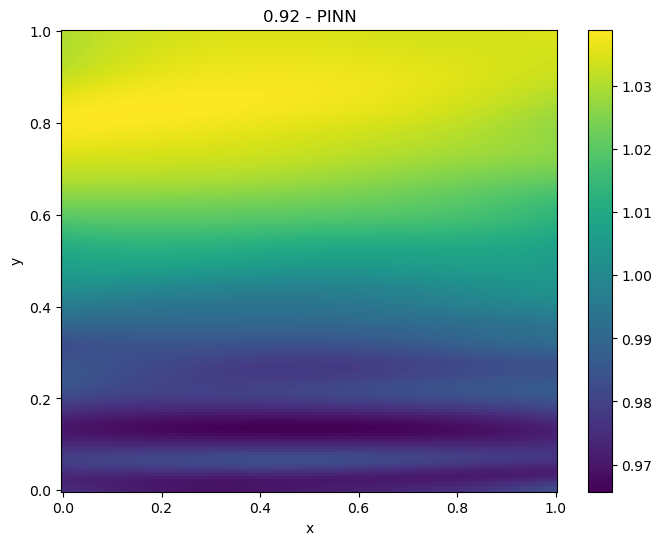

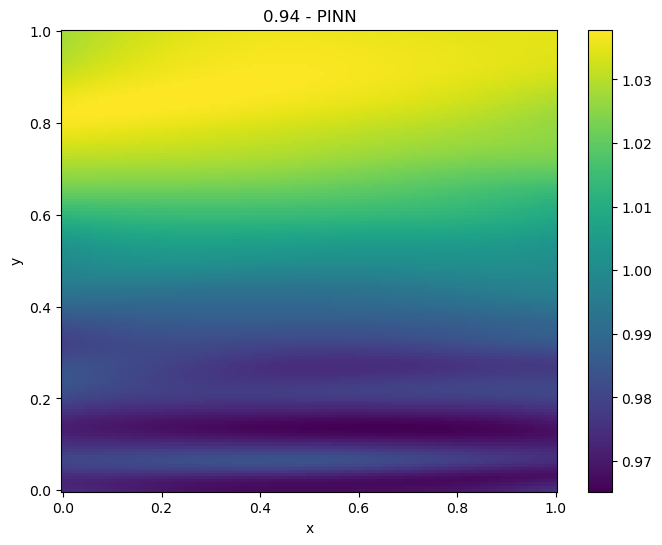

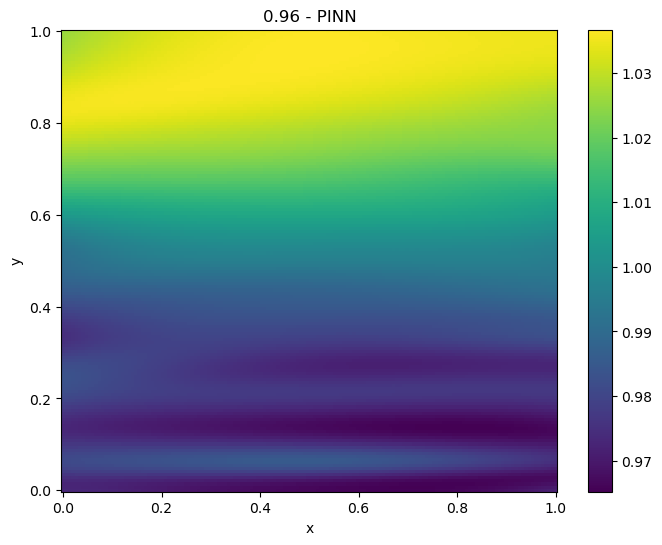

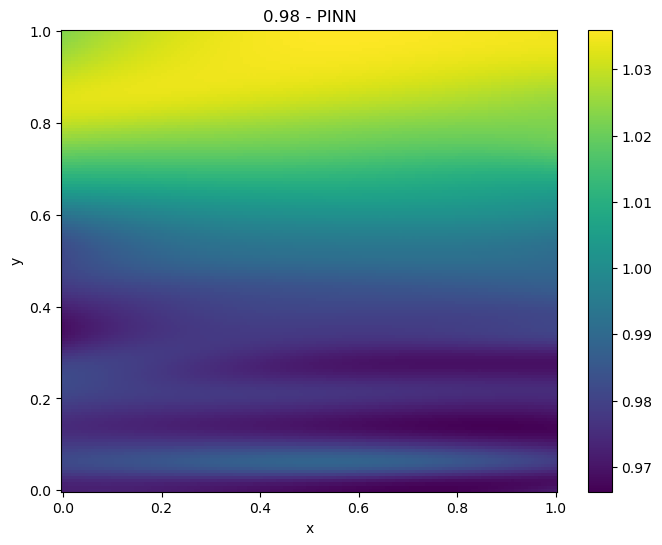

In [176]:
# Loss function

losses = loss_fn.verbose(pinn)
print(f'Total loss: \t{losses[0]:.5f}    ({losses[0]:.3E})')
print(f'Interior loss: \t{losses[1]:.5f}    ({losses[1]:.3E})')
print(f'Initial loss: \t{losses[2]:.5f}    ({losses[2]:.3E})')
print(f'Bondary loss: \t{losses[3]:.5f}    ({losses[3]:.3E})')

average_loss = running_average(loss_values, window=100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Loss function (runnig average)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(average_loss)
ax.set_yscale('log')

average_loss = running_average(loss_residual_values, window=100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Loss function (residual) (runnig average)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(average_loss)
ax.set_yscale('log')

average_loss = running_average(loss_initial_values, window=100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Loss function (initial) (runnig average)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(average_loss)
ax.set_yscale('log')

average_loss = running_average(loss_boundary_values, window=100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Loss function (boundary) (runnig average)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(average_loss)
ax.set_yscale('log')

# Initial condition

x, y, _ = get_initial_points(x_domain, y_domain, t_domain, N_POINTS_PLOT, requires_grad=False)
z = initial_condition(x, y)
fig = plot_color(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - exact")

t_value = 0.0
t = torch.full_like(x, t_value)
z = pinn(x, y, t)
fig = plot_color(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - PINN")

for t in range(1, 50):
  t_value = t / 50
  t_1 = torch.full_like(x, t_value)
  z = pinn(x, y, t_1)
  fig = plot_color(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, f"{t_value} - PINN")

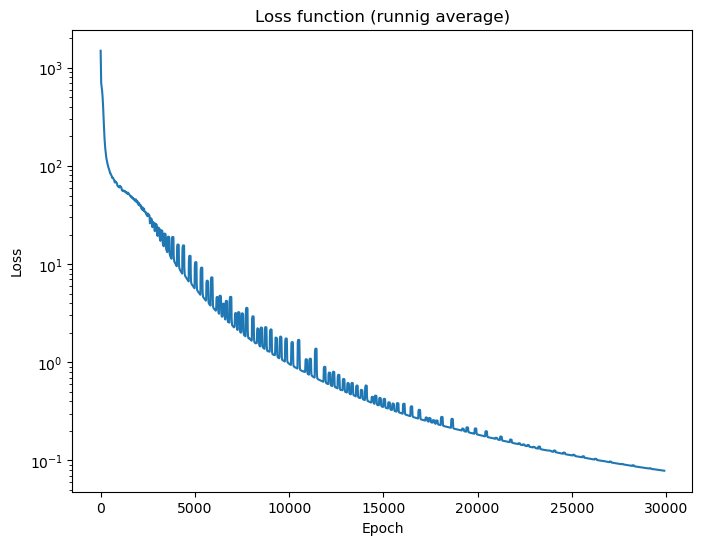

In [177]:
# Loss function
average_loss = running_average(loss_values, window=100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Loss function (runnig average)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(average_loss)
ax.set_yscale('log')

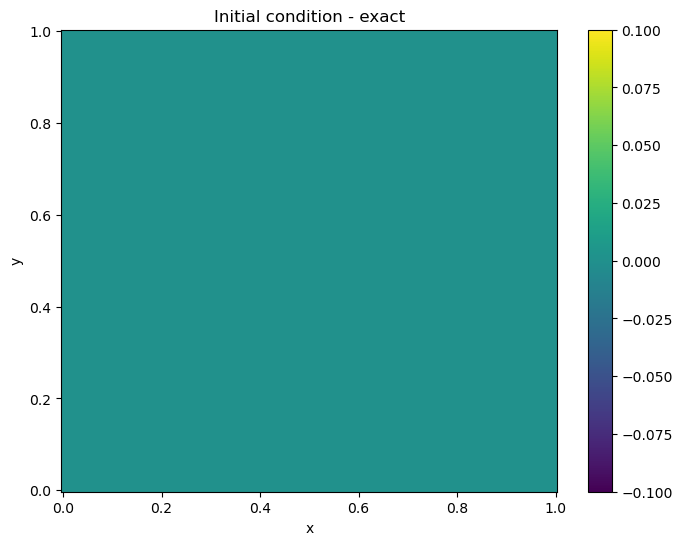

In [178]:
# Initial condition
x, y, _ = get_initial_points(x_domain, y_domain, t_domain, N_POINTS_PLOT, requires_grad=False)
z = initial_condition(x, y)
fig = plot_color(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - exact")

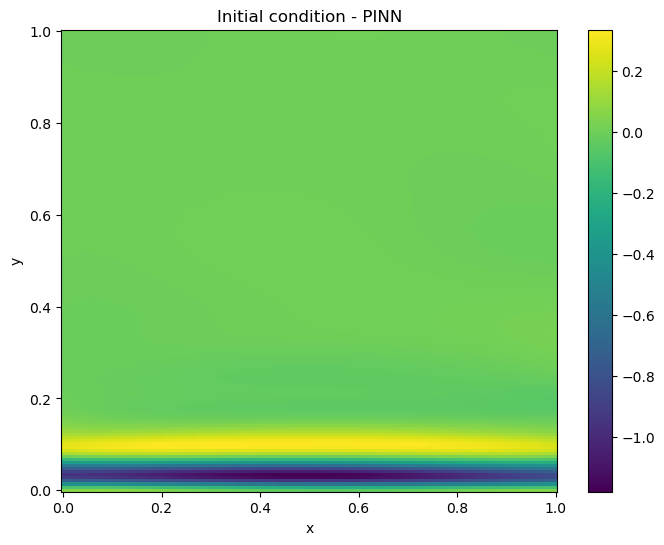

In [179]:
t_value = 0.0
t = torch.full_like(x, t_value)
z = pinn(x, y, t)
fig = plot_color(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - PINN")

In [180]:

# x, y, _ = get_initial_points(x_domain, y_domain, t_domain, N_POINTS_PLOT, requires_grad=False)
# z = initial_condition(x, y)
# fig = plot_3D(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - exact", limit=0.5)

for t in range(0, 10):
    continue
    t_value = t / 10
    t = torch.full_like(x, t_value)
    z = pinn(x, y, t)
    fig = plot_3D(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, f"PINN for t = {t_value}", limit=3)